# Machine Learning for Multibody System Dynamics

## **Session 2-3:** Surrogate Modeling: Duffing Oscillator with External Forcing Revised

Grzegorz Orzechowski & Peter Manzl

> DNN trained on Duffing‐oscillator equations of motion, not on its response.

## Imports and Setup

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import random

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Generate supervised data 

 $(u, F)\mapsto\dot u$ using the analytic Duffing RHS.

In [2]:
# 2) Generate supervised data: (x, v, F) -> (dx/dt, dv/dt)

# parameters
N = 5_000
m = 1.0
k = 1600.0
damp = 8.0
alpha = 1.0

def duffing_equation(F, x, v):
    return F - damp * v - k * x - alpha * k * x**3

# preallocate
X = np.zeros((N, 3), dtype=np.float32)  # [x, v, F]
Y = np.zeros((N, 2), dtype=np.float32)  # [dx, dv]

rng = np.random.default_rng(seed=42)
for i in range(N):
    x = rng.random() * 2 - 1
    v = (rng.random() * 2 - 1) * 100
    F = (rng.random() * 2 - 1) * 2000

    dx = (1 + 0.05 * rng.standard_normal()) * v
    dv = (1 + 0.05 * rng.standard_normal()) * duffing_equation(F, x, v)

    X[i] = [x, v, F]
    Y[i] = [dx, dv]


## Standardize inputs and outputs

In [3]:
# 3) Standardize inputs and outputs
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
Y_scaled = scaler_Y.fit_transform(Y)

## Build the MLP surrogate model

In [ ]:
# 4) Build the MLP surrogate model

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_sizes, output_dim, dropout_rate=0.0, activation=nn.SiLU):
        super().__init__()
        layers = []
        in_dim = input_dim
        for h in hidden_sizes:
            layers.append(nn.Linear(in_dim, h))
            layers.append(activation())
            if dropout_rate > 0:
                layers.append(nn.Dropout(dropout_rate))
            in_dim = h
        layers.append(nn.Linear(in_dim, output_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

In [ ]:
# settings
hidden_dims   = [128, 128]
dropout_rate  = 0.011
activation    = nn.SiLU
batch_size    = 64
learning_rate = 1e-3
weight_decay  = 1e-4
patience      = 50
n_epochs      = 2000

model = MLP(3, hidden_dims, 2, dropout_rate, activation).to(device)

## Prepare DataLoaders

In [5]:
# 5) Prepare DataLoaders (80% train, 20% val)
indices = np.arange(N)
np.random.shuffle(indices)
split = int(0.8 * N)
train_idx, val_idx = indices[:split], indices[split:]

X_train = torch.from_numpy(X_scaled[train_idx]).float().to(device)
Y_train = torch.from_numpy(Y_scaled[train_idx]).float().to(device)
X_val   = torch.from_numpy(X_scaled[val_idx]).float().to(device)
Y_val   = torch.from_numpy(Y_scaled[val_idx]).float().to(device)

train_loader = DataLoader(TensorDataset(X_train, Y_train),
                          batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val,   Y_val),
                          batch_size=batch_size, shuffle=False)


## Training loop with early stopping

In [6]:
# 6) Training loop with early stopping
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

train_loss_hist = []
val_loss_hist   = []
best_val = float('inf')
no_improve = 0

for epoch in range(1, n_epochs + 1):
    # Training
    model.train()
    total_train = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_train += loss.item()
    train_loss_hist.append(total_train / len(train_loader))

    # Validation
    model.eval()
    total_val = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            preds = model(xb)
            total_val += criterion(preds, yb).item()
    val_loss = total_val / len(val_loader)
    val_loss_hist.append(val_loss)

    # Early stopping
    if val_loss < best_val:
        best_val = val_loss
        no_improve = 0
        best_state = model.state_dict()
    else:
        no_improve += 1
        if no_improve >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

# load best model
model.load_state_dict(best_state)
print(f"Final validation loss: {val_loss_hist[-1]:.6f}")

Early stopping at epoch 127
Final validation loss: 0.002786


## Plot losses

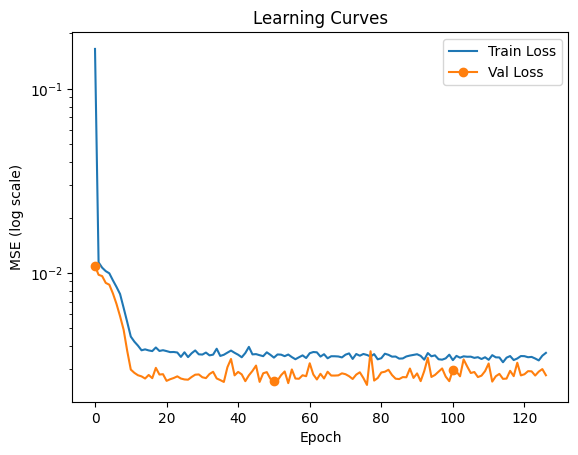

In [7]:
# 7) Plot training & validation loss
plt.figure()
plt.semilogy(train_loss_hist, label='Train Loss')
plt.semilogy(val_loss_hist,   label='Val Loss', marker='o', markevery=50)
plt.xlabel('Epoch')
plt.ylabel('MSE (log scale)')
plt.legend()
plt.title('Learning Curves')
plt.show()

## Compare Surrogate vs True Trajectory

Select a random test forcing sequence and plot the true Duffing integration against the surrogate’s prediction.


In [8]:
# 8) Define ODE right‐hand sides
model.eval()  # dropout off
def surrogate_rhs(t, u, forces, h):
    # u = [x, v]
    idx = min(int(t / h), len(forces)-1)
    F_t = forces[idx]
    inp = np.array([[u[0], u[1], F_t]], dtype=np.float32)
    inp_s = scaler_X.transform(inp)
    with torch.no_grad():
        dud_s = model(torch.from_numpy(inp_s).to(device)).cpu().numpy()
    dud = scaler_Y.inverse_transform(dud_s)
    return [dud[0,0], dud[0,1]]

def duffing_rhs(t, u, forces, h):
    idx = min(int(t / h), len(forces)-1)
    F_t = forces[idx]
    x, v = u
    return [v, duffing_equation(F_t, x, v)]


### Simulate and compare

In [9]:
# 9) Simulate and compare
n_steps = 64
h = 0.5 / 64
t_span = (0.0, h * n_steps)
t_eval = np.linspace(*t_span, n_steps+1)
forces = (rng.standard_normal(n_steps) - 0.5) * 2000

u0 = [0.1, 0.0]

# surrogate solution
sol_sur = solve_ivp(fun=lambda t, y: surrogate_rhs(t, y, forces, h),
                    t_span=t_span, y0=u0, t_eval=t_eval, method='RK45')

# true solution
sol_true = solve_ivp(fun=lambda t, y: duffing_rhs(t, y, forces, h),
                     t_span=t_span, y0=u0, t_eval=t_eval, method='RK45')


###  Plot trajectories

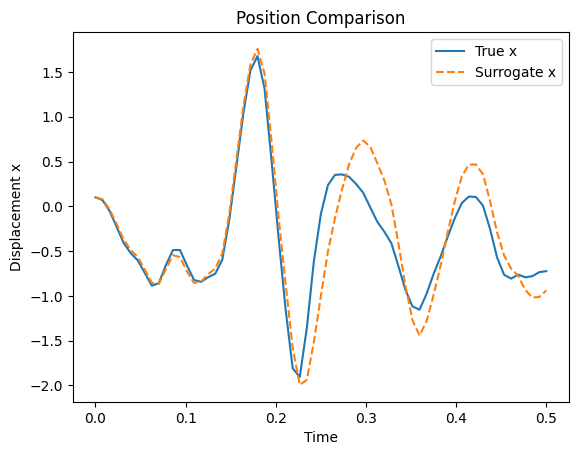

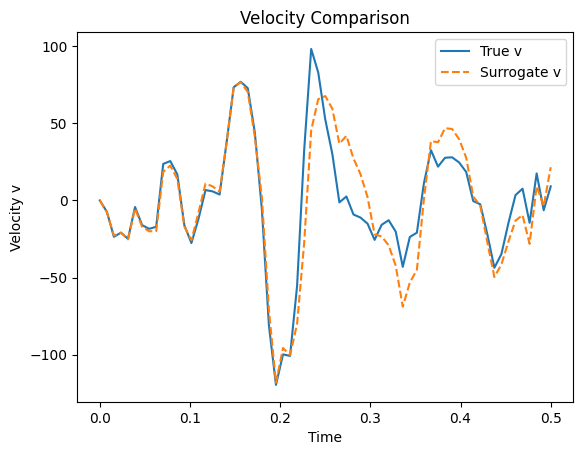

In [10]:
# 10) Plot trajectories
plt.figure()
plt.plot(sol_true.t, sol_true.y[0], label='True x')
plt.plot(sol_sur .t, sol_sur .y[0], '--', label='Surrogate x')
plt.xlabel('Time')
plt.ylabel('Displacement x')
plt.legend()
plt.title('Position Comparison')
plt.show()

plt.figure()
plt.plot(sol_true.t, sol_true.y[1], label='True v')
plt.plot(sol_sur .t, sol_sur .y[1], '--', label='Surrogate v')
plt.xlabel('Time')
plt.ylabel('Velocity v')
plt.legend()
plt.title('Velocity Comparison')
plt.show()


## Final Notes

If possible, you should train network on your eqations of motion, not the reposnse. 

**Next, let's take a quick look at classificaiton problem.**

[2-4_ClearanceClassifier](./2-4_ClearanceClassifier.ipynb)